In [1]:
from sklearn.model_selection import train_test_split
import sqlite3
import pickle
import numpy as np
import keras
from keras.utils import to_categorical


def load_and_split_dataset(database_path='lfw_dataset.db', test_size=0.2, random_state=0):
    # Connecting to the SQLite database
    conn = sqlite3.connect(database_path)
    cursor = conn.cursor()

    # Retrieving data from the database
    cursor.execute('SELECT target, name, image FROM faces')
    rows = cursor.fetchall()

    # Close the connection
    conn.close()

    # Splitting the dataset into features (X) and labels (y)
    images = []
    names = []
    targets = []

    for row in rows:
        target, name, image_bytes = row
        # Deserialize the image data
        image_data = pickle.loads(image_bytes)
        image_data_normalized = image_data
        images.append(image_data_normalized)
        names.append(name)
        targets.append(target)
    num_classes = len(np.unique(targets))
    X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=test_size, random_state=random_state)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # Print the shapes of the resulting sets
    print("Training set shape:", X_train.shape, y_train.shape)
    print("Testing set shape:", X_test.shape, y_test.shape)

    # Plot the first image in X_train
    plt.imshow(X_train[0])
    plt.title('First Image in X_train')
    plt.show()

    return X_train, X_test, y_train, y_test, num_classes, names

In [2]:

def preprocess_and_print_shapes(y_train, y_test):
    y_train_categorical = keras.utils.to_categorical(y_train, num_classes)
    y_test_categorical = keras.utils.to_categorical(y_test, num_classes)

    print("Training set shape:", X_train.shape, y_train.shape)
    print("Testing set shape:", X_test.shape, y_test.shape)

    return y_train_categorical, y_test_categorical

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def train_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [4]:
def get_accuracy(model):
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test accuracy:', score[1])

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, X_test, y_test, num_rows=5, num_cols=5, figsize=(20, 20)):
    # Make predictions on the test set
    predicted_probabilities = model.predict(X_test)
    predicted_classes = np.argmax(predicted_probabilities, axis=1)

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.ravel()

    # Loop through the test set and visualize predictions
    for i in range(num_rows * num_cols):
        actual_name = np.argmax(y_test, axis=1)[i]
        predicted_name = predicted_classes[i]

        axes[i].imshow(X_test[i])
        axes[i].set_title("Prediction Class = {}\nTrue Class = {}".format(predicted_name, actual_name))
        axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5)
    plt.show()


Training set shape: (2418, 62, 47, 3) (2418,)
Testing set shape: (605, 62, 47, 3) (605,)


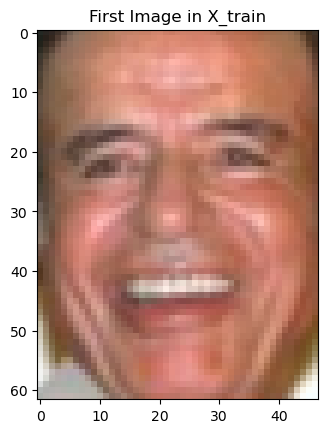

Training set shape: (2418, 62, 47, 3) (2418,)
Testing set shape: (605, 62, 47, 3) (605,)
Epoch 1/10
242/242 [==============================] - 4s 16ms/step - loss: 3.7404 - accuracy: 0.1654 - val_loss: 3.6787 - val_accuracy: 0.1752
Epoch 2/10
242/242 [==============================] - 4s 15ms/step - loss: 3.5018 - accuracy: 0.1869 - val_loss: 3.2839 - val_accuracy: 0.2248
Epoch 3/10
242/242 [==============================] - 3s 13ms/step - loss: 2.8382 - accuracy: 0.2998 - val_loss: 2.6532 - val_accuracy: 0.3157
Epoch 4/10
242/242 [==============================] - 3s 13ms/step - loss: 2.0807 - accuracy: 0.4545 - val_loss: 1.9800 - val_accuracy: 0.4926
Epoch 5/10
242/242 [==============================] - 3s 14ms/step - loss: 1.5247 - accuracy: 0.5819 - val_loss: 1.7502 - val_accuracy: 0.5636
Epoch 6/10
242/242 [==============================] - 3s 14ms/step - loss: 1.1070 - accuracy: 0.6898 - val_loss: 1.6965 - val_accuracy: 0.5884
Epoch 7/10
242/242 [==============================] -

/Users/shahd.metwally/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 0s 11ms/step


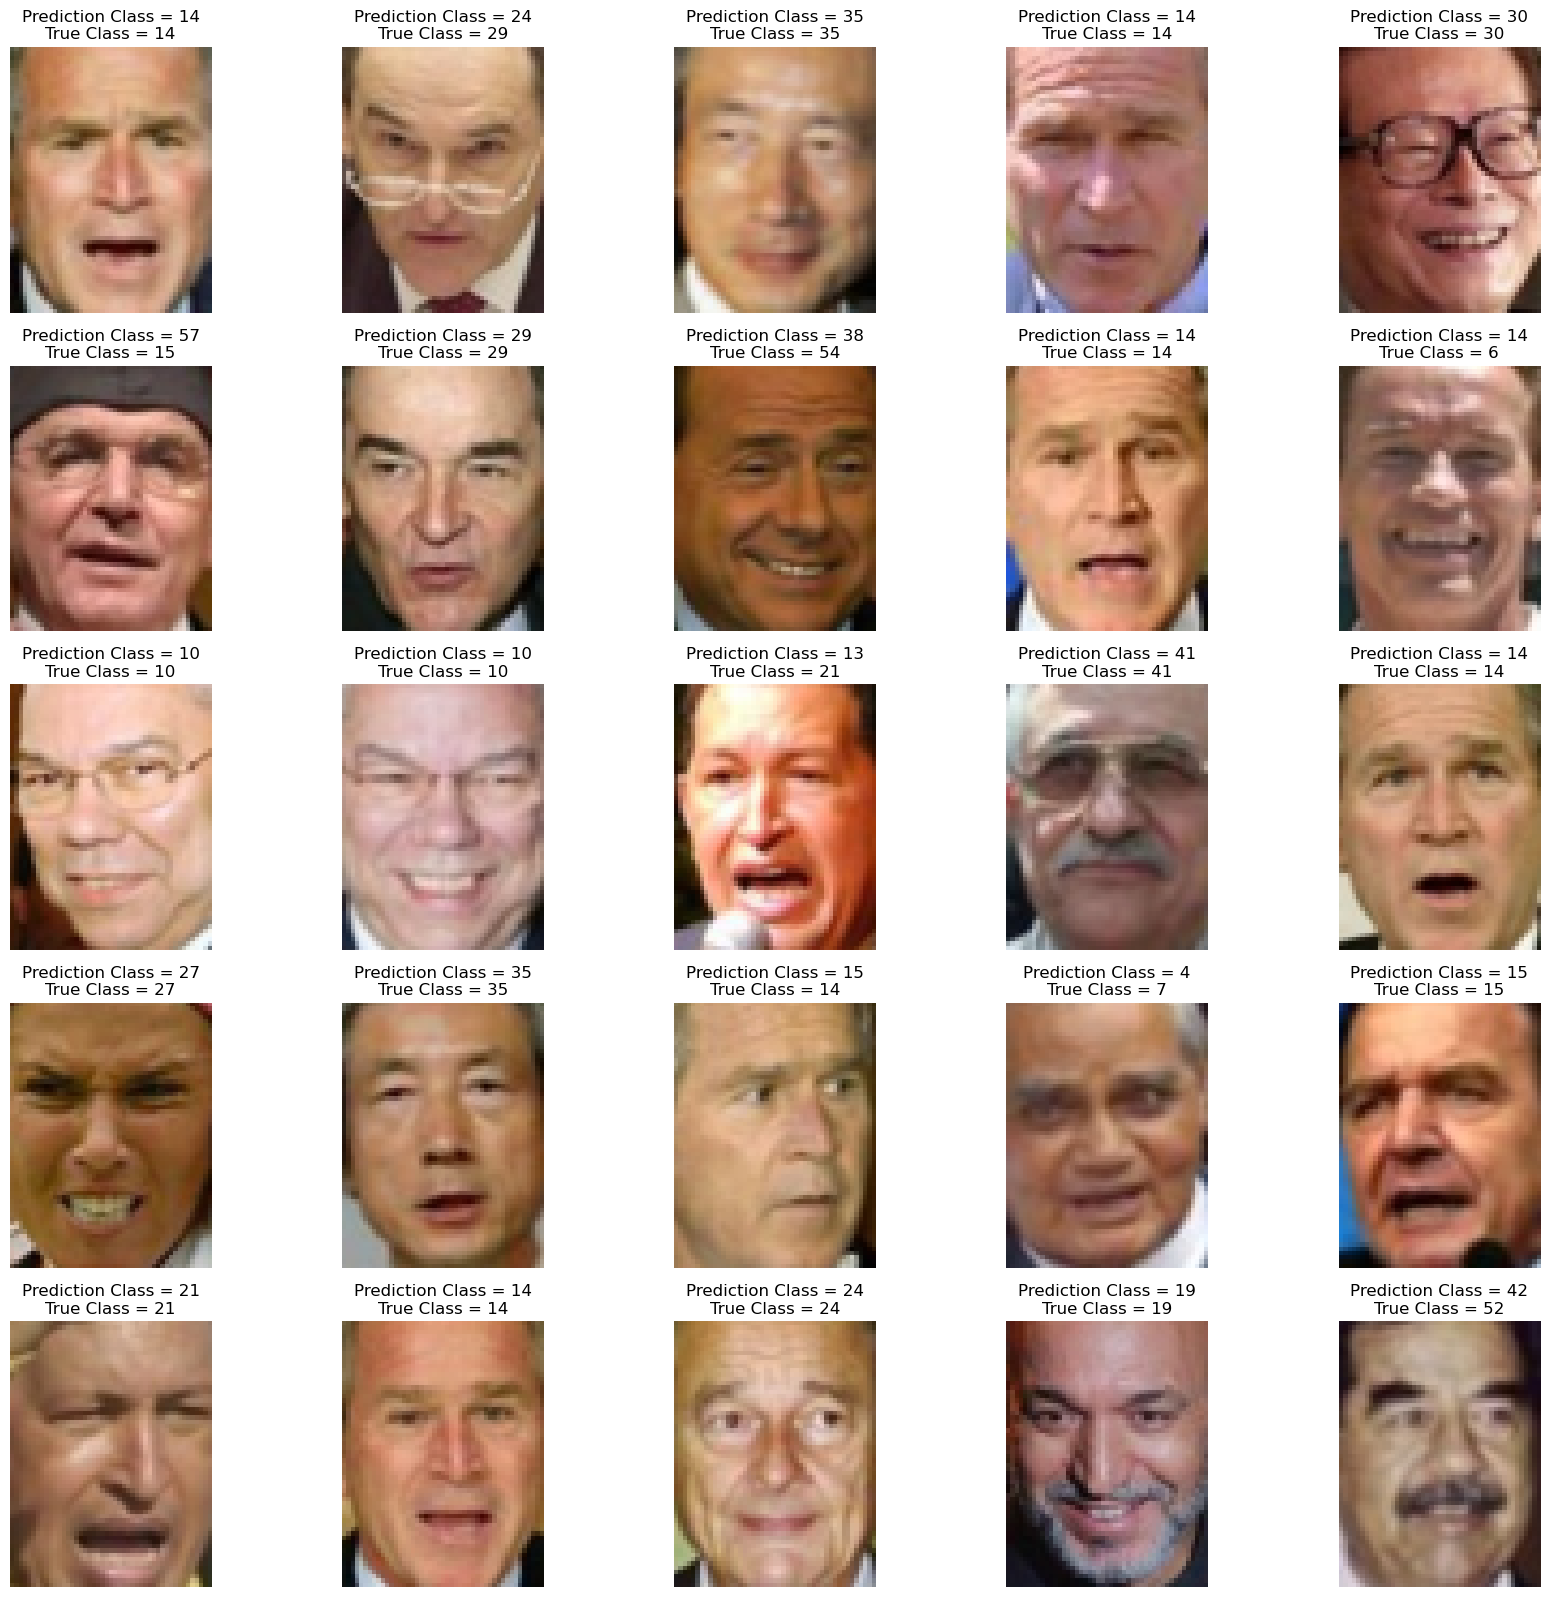

In [6]:

X_train, X_test, y_train, y_test, num_classes, names = load_and_split_dataset()
y_train, y_test = preprocess_and_print_shapes(y_train, y_test)

input_shape = (62, 47, 3)
cnn_model = train_cnn_model(input_shape, num_classes)

# Train the model
hist = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=10)
get_accuracy(cnn_model)

# Save the trained model
cnn_model.save('trained_model.h5')

# Assuming lfw_dataset.target_names contains class names
visualize_predictions(cnn_model, X_test, y_test)